# Out-of-bag error and feature selection

Семинар основан на <a href="https://habr.com/en/company/ods/blog/324402/">материале</a> ODS

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.special import binom
from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits as load
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

%matplotlib inline

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Out-of-bag error

----------

<img src='img/oob.png' width=700>

**Задача** Покажите, что примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.

**Решение** Пусть в выборке $l$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью $\dfrac{1}{l}$. Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $l$ раз): $(1-\dfrac{1}{l})^l$


$$\lim_{l \rightarrow +\infty} (1-\dfrac{1}{l})^l = \dfrac{1}{e}$$

Тогда вероятность попадания конкретного объекта в подвыборку $1 - \dfrac{1}{e} \approx 63\%$.

Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

## Отбор признаков с помощью случайного леса

<img src='img/features.png'>

Данные можно взять здесь: https://github.com/Yorko/mlcourse_open/blob/master/data/hostel_factors.csv

In [4]:
#!wget https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/hostel_factors.csv -O data/hostel_factors.csv

--2019-03-16 23:13:41--  https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/hostel_factors.csv
Resolving raw.githubusercontent.com... 151.101.112.133
Connecting to raw.githubusercontent.com|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2873 (2.8K) [text/plain]
Saving to: ‘data/hostel_factors.csv’

data/hostel_factors 100%[===================>]   2.81K  --.-KB/s    in 0s      

2019-03-16 23:13:42 (12.6 MB/s) - ‘data/hostel_factors.csv’ saved [2873/2873]



In [5]:
hostel_data = pd.read_csv("data/hostel_factors.csv")
features = {
    "f1":u"Персонал",
    "f2":u"Бронирование хостела ",
    "f3":u"Заезд в хостел и выезд из хостела",
    "f4":u"Состояние комнаты",
    "f5":u"Состояние общей кухни",
    "f6":u"Состояние общего пространства",
    "f7":u"Дополнительные услуги",
    "f8":u"Общие условия и удобства",
    "f9":u"Цена/качество",
    "f10":u"ССЦ",
}

In [6]:
forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

Feature ranking:
1. Персонал 0.182757 
2. Цена/качество 0.148373 
3. Состояние общего пространства 0.128296 
4. Дополнительные услуги 0.116604 
5. ССЦ 0.106668 
6. Общие условия и удобства 0.088589 
7. Состояние общей кухни 0.074273 
8. Заезд в хостел и выезд из хостела 0.061521 
9. Бронирование хостела  0.053615 
10. Состояние комнаты 0.039305 


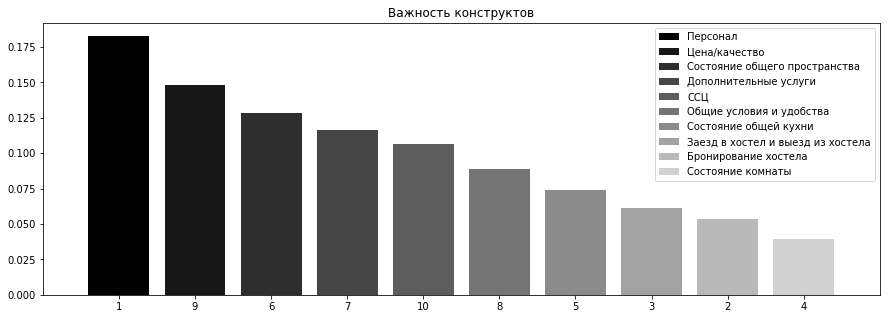

In [7]:
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, features["f"+str(feature_indices[f])], importances[indices[f]]))

plt.figure(figsize=(15, 5))

bars = plt.bar(range(num_to_plot), importances[indices[:num_to_plot]], color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]), align="center")
ticks = plt.xticks(range(num_to_plot), feature_indices)

plt.xlim([-1, num_to_plot])
plt.title(u"Важность конструктов")
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices])

<h1 align="center">Выводы</h1> 

**Bagging**:
    - Одна из лучших техник для построения алгоритмов ML
    - Линейно уменьшает разброс и не уменьшает смещение (если не коррелированы ответы базовых алоритмов) 
    - Слабое переобучение
    - НО переобучение ЕСТЬ -- от сложности одного алгоритма, лучше все же немного обрезать деревья

** Random Forest **

Плюсы:
- имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
- практически не чувствителен к выбросам в данных из-за случайного сэмлирования
- не чувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
- не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
- способен эффективно обрабатывать данные с большим числом признаков и классов
- одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
- редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
- для случайного леса существуют методы оценивания значимости отдельных признаков в модели
- хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
- предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
- вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
- возможности, описанные выше, могут быть расширены до неразмеченных данных, что приводит к возможности делать кластеризацию и визуализацию данных, обнаруживать выбросы
- высокая параллелизуемость и масштабируемость.

Минусы:
- в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
- нет формальных выводов (p-values), доступных для оценки важности переменных
- алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
- случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
- алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
- для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение оптимизируемого функционала (типа прироста информации)
- если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
- больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.